In [1]:
import pandas as pd
from importlib import reload
import utils as d; reload(d)
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider

# Dataset

## Load

In [2]:
df = d.load_dataset()

## Create X and Y

In [3]:
PREDICTED_COLUMNS = ['diagnosis']
FEATURES = ['mean']
x, y = d.create_xy(df, FEATURES, PREDICTED_COLUMNS)

In [4]:
x = d.preprocess_data(x)
N_FEATURES = x.shape[-1]

## Split Train, Val & Test

In [5]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = d.split_train_val_test(x, y, train_perc=0.6)

In [6]:
print('# Examples for training:', len(x_train))
print('# Examples for validation:', len(x_val))
print('# Examples for test:',  len(x_test))

# Examples for training: 214
# Examples for validation: 177
# Examples for test: 178


# Comparing Outlier detection methods

- Which features am I taking into account to detect outliers? 
    - Univariate 
        - Box plots, Z-Scores
    - Multivariate
- Can I assume a distribution(s) of values for my selected features? 
    - Parametric 
        - Z-Score, IQR score
    - Non-parametric
        - PCA, LMS, Proximity Based Models

### Sources of outliers

* Data entry errors
* Measurement errors (instrument errors)
* Experimental errors (data extraction or experiment planning/executing errors)
* Natural (not an error, novelties in data)

## Interquartile Range (IQR) score

![title](http://www.statisticshowto.com/wp-content/uploads/2012/03/iqr.jpg)

In [7]:
def get_iqr_score(x):
    q1 = pd.DataFrame(x).quantile(0.25).values
    q3 = pd.DataFrame(x).quantile(0.75).values
    IQR = q3 - q1
    return IQR, q3, q1

IQR, q3, q1 = get_iqr_score(x_test)

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

k = FloatSlider(min=0, max=2.0, step=.05)
threshold_vote_outlier = FloatSlider(min=0, max=1, step=.01)

ui = widgets.HBox([k, threshold_vote_outlier])

def plot(x, outliers_idx, real_outlier_index):
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(111)
    ax.scatter(x[~outliers_idx, 0], x[~outliers_idx, 1], alpha=0.7, label='Inliers', c='r')
    ax.scatter(x[outliers_idx, 0], x[outliers_idx, 1], alpha=0.7, label='Predicted outliers', c='g')
    ax.scatter(x[real_outlier_index, 0], x[real_outlier_index, 1], alpha=0.4, label='Real outliers', c='b')

    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    
def iqr_get_outliers(x, spread, threshold):
    x_pca = pca.fit(x).transform(x)
    outliers_candidates = (x < (q1 - spread * IQR)) | (x > (q3 + spread * IQR))
    outliers_idx = np.apply_along_axis(lambda c: c.mean() >= threshold, 1, outliers_candidates) 
    return x_pca, outliers_idx

data, target = x_test, y_test
real_outliers_idx = (target[:, 0] == 'M')

def f(k, threshold_vote_outlier):    
    x_pca, outliers_idx = iqr_get_outliers(data, k, threshold_vote_outlier)
    d.plot_confusion_matrix(confusion_matrix(real_outliers_idx, outliers_idx), [False, True])
    plot(x_pca, outliers_idx, real_outliers_idx)
    

out = widgets.interactive_output(f, {'k': k, 'threshold_vote_outlier': threshold_vote_outlier})
display(ui, out)

Output()

### Grid Search for Hyperparameters

In [9]:
y_val_true = y_val[:, 0] == 'M'

In [10]:
_, w = np.unique(y_val_true, return_counts=True)

In [11]:
weights = [w[0] if y == True else w[1] for y in y_val_true]

In [12]:
acc = []
param = []

for k in np.arange(0, 2, 0.1):
    for th in np.arange(0, 1, 0.1):
        x_pca, outliers_idx = iqr_get_outliers(x_val, k, th)
        acc.append(accuracy_score(y_val_true, outliers_idx, sample_weight=weights))
        param.append((k, th))

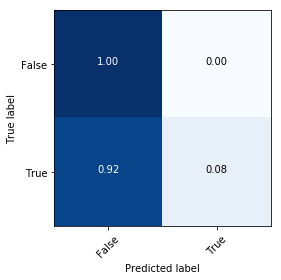

In [13]:
k, th = param[np.argmax(acc)]
x_pca, outliers_idx = iqr_get_outliers(x_test, k, th)
d.plot_confusion_matrix(confusion_matrix((y_test[:, 0] == 'M'), outliers_idx), [False, True])
plt.show()

## Isolation Forest

* Separate each point from its neighbors
    - If it is a inlier, it will take longer to separate
    - If it is a outlier, it will separate rapidly
    
* Works well for multiple dimentions

<div style="text-align:center"><img width="700px" src="images/outlier2.gif"></div>
<br>
<br>
<div style="text-align:center">Figure 1: Isolating Outlier.</div>

<div style="text-align:center"><img width="700px" src="images/inlier2.gif"></div>
<br>
<br>
<div style="text-align:center">Figure 2: Isolating Inlier.</div>

In [14]:
from sklearn.ensemble import IsolationForest

In [15]:
x_test_df = pd.DataFrame(x_test, columns=x.columns)

In [ ]:
fig, axs = plt.subplots(N_FEATURES, figsize=(22, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(x_test_df.columns):
    isolation_forest = IsolationForest()
    isolation_forest.fit(x_test_df[column].values.reshape(-1,1))

    xx = np.linspace(x_test_df[column].min(), x_test_df[column].max(), len(x_test_df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)
fig
plt.show()

In [ ]:
data = np.vstack([x_train, x_val])
contamination = sum(y_val == 'M') / (len(y_val) + len(y_train))
model = IsolationForest(contamination=contamination)
model.fit(data)

In [ ]:
outliers = pd.Series(model.predict(x_test)).map({-1: True, 1: False})
d.plot_confusion_matrix(confusion_matrix(y_test[:, 0] == 'M', outliers), [False, True])
plt.show()

In [ ]:
plt.title('Anomaly Score')
plt.plot(model.decision_function(x_test))
plt.show()

Done!